In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime

In [2]:
sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(15,8)})

In [3]:
# read factors
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
factors_returns = pd.read_csv('factors_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)
strategy_returns = pd.read_csv('strategy_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)

In [4]:
def freward(weights):
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    tracking_error =  (pred_returns.values - strategy_returns.iloc[:,0].values)
    return -np.sqrt(np.mean(tracking_error**2))

In [5]:
def freward_teacher(weights):
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    tracking_error =  (pred_returns.values - strategy_returns.iloc[:,0].values
        ) * np.sqrt(250) * np.sqrt(weights.shape[1]+1)
    turn_over = 0.0020 * 365 * ((weights - weights.shift(1)).abs().fillna(0).values
        ) / ((weights.index[-1] -weights.index[0]).days) * np.sqrt(
        weights.shape[0] * (weights.shape[1]+1)) 
    error_terms = np.concatenate([tracking_error, turn_over.flatten()], axis=0)
    return -np.sqrt(np.mean(error_terms**2))

In [6]:
strategy_returns.head(10)

,Last Price
Date,
2010-01-04,0.000000
2010-01-05,0.002270
2010-01-06,0.004127
2010-01-07,0.000179
2010-01-08,0.001401
2010-01-11,0.002056
2010-01-12,-0.001762
2010-01-13,-0.000401
2010-01-14,0.001357


In [7]:
def buildPrices(dataframe,base):
    df= pd.DataFrame()
    for name in dataframe.columns:
        df[name+' price']= base * (1 + dataframe[name]).cumprod()
    return df

In [8]:
0.1/ np.sqrt(250)

0.006324555320336759

In [9]:
# read factors
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
factors_returns = pd.read_csv('factors_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)
strategy_returns = pd.read_csv('strategy_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)

# create simple random weights (equal weight plus some noise 4% per annum)
data = np.tile( [1/factors_returns.shape[1]] * factors_returns.shape[1], 
               factors_returns.shape[0]).reshape(factors_returns.shape)
weights = pd.DataFrame(index=factors_returns.index, columns = factors_returns.columns, data=data)
weights += np.random.normal(0, 0.04/ np.sqrt(250), weights.shape)
print(strategy_returns)

            Last Price
Date                  
2010-01-04    0.000000
2010-01-05    0.002270
2010-01-06    0.004127
2010-01-07    0.000179
2010-01-08    0.001401
...                ...
2022-02-03   -0.002747
2022-02-04   -0.000319
2022-02-07    0.000347
2022-02-08    0.001770
2022-02-09    0.003407

[3058 rows x 1 columns]


In [10]:
 factors_returns.head()

,Bloomberg Commodities,Dollar Index,EM Bond USD,EU Global Aggregate,EU HY,EU Stoxx 600,Japan Nikkei 225,MSCI EM USD,US Global Aggregate,US HY,US S&P 500
Date,,,,,,,,,,,
2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-05,-0.001329,0.000467,0.004215,0.001062,0.007361,-0.000215,0.002538,0.010706,0.004409,0.002218,0.003119
2010-01-06,0.020527,0.000061,0.000460,-0.000679,0.006578,0.001435,0.004645,0.006396,-0.000904,0.007291,0.000850
2010-01-07,-0.015051,0.005292,-0.000300,0.001803,0.006402,0.000334,-0.004640,-0.007172,-0.000517,0.003488,0.004046
2010-01-08,-0.003042,-0.004810,0.000482,0.000787,0.004789,0.004298,0.010921,0.001963,0.000899,0.003684,0.002880


In [11]:
df = buildPrices(factors_returns,100)

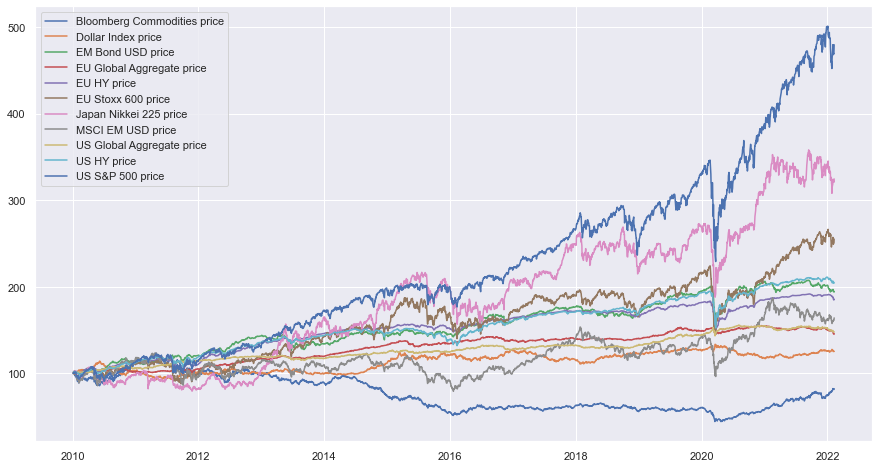

In [12]:
plt.plot(df)
plt.legend(df.columns,loc='upper left')

In [13]:
df['Strategy price']= 100 * (1 + strategy_returns['Last Price']).cumprod()

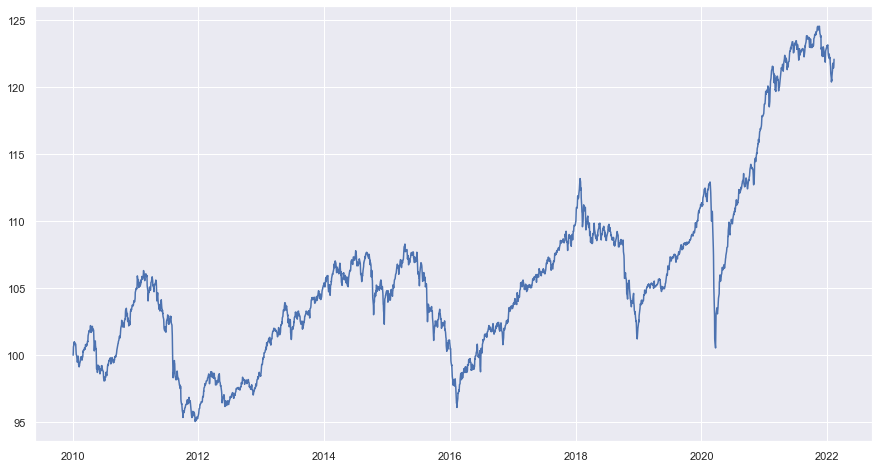

In [14]:
plt.plot(df['Strategy price'])

# DDPG

In [15]:
import sys
import copy
import matplotlib.pyplot as plt
from itertools import count
from datetime import datetime
from envmkt import Decode_v1
from ddpg import DDPGagent
from utils import *

C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
env = Decode_v1(factors_returns=factors_returns,strategy_returns=strategy_returns,random_start=False,window=7)

In [17]:
agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
nb_episodes = 500

In [18]:
rewards = []
avg_rewards = []
best_env = env
best_reward = -100

for episode in range(nb_episodes):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    
    for step in count():
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        if step % 1500 ==0:
            print(action)
            print(np.linalg.norm(action))
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state 
        episode_reward += reward 

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            print(f'Env reward is {freward_teacher(env.weights_df)}')
            if freward_teacher(env.weights_df) > best_reward :
                best_env = copy.deepcopy(env)
                best_reward = freward_teacher(env.weights_df)
                print(f'best reward has been set to {best_reward}')
                print('\x1b[6;30;42m' + 'best_env has been changed' + '\x1b[0m')
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards))

[ 0.03551835  0.00205467  0.01307977 -0.00682477 -0.01949272 -0.02767871
  0.04228906 -0.06589534  0.02945905 -0.1176878   0.03876755]
0.15805456631379197
[ 0.03929752 -0.06750783  0.04477049 -0.05507319  0.06637019 -0.08459691
 -0.00587309 -0.03276215 -0.00635399 -0.11390648  0.03697164]
0.1954239140380478
[-0.06565287 -0.0093363   0.00798476 -0.05650965 -0.03926289  0.00320257
  0.03126123 -0.0395626  -0.0423442  -0.06506361 -0.00089746]
0.1333265460924921


C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode: 0, reward: -8.63, average _reward: nan 
Env reward is -0.051527646114001575
best reward has been set to -0.051527646114001575
best_env has been changed
[-0.08221109 -0.03056476 -0.00285681 -0.06041273 -0.04735669  0.00131939
  0.00855915 -0.04181841 -0.00685512 -0.07209716 -0.05802965]
0.1550148255360461
[-0.04295749 -0.0171122  -0.06236496 -0.04818984 -0.02027544 -0.02261203
  0.01207617 -0.01791751 -0.02529619  0.03489972 -0.03577813]
0.11347710715242261
[-0.03730284 -0.0360765  -0.04159382 -0.01383857 -0.02997335 -0.05778577
 -0.04335045 -0.05225728 -0.03523462 -0.03021796 -0.05709911]
0.13739417445368263
episode: 1, reward: -5.71, average _reward: -8.632973325036215 
Env reward is -0.04605036876502933
best reward has been set to -0.04605036876502933
best_env has been changed
[-0.03577674 -0.03926423 -0.0559687  -0.02589608 -0.04338455 -0.05783754
 -0.05922301 -0.0469319  -0.0350212  -0.0524829  -0.077334  ]
0.16590241951701337
[-0.05794607 -0.06560127 -0.01857728 -0.009576

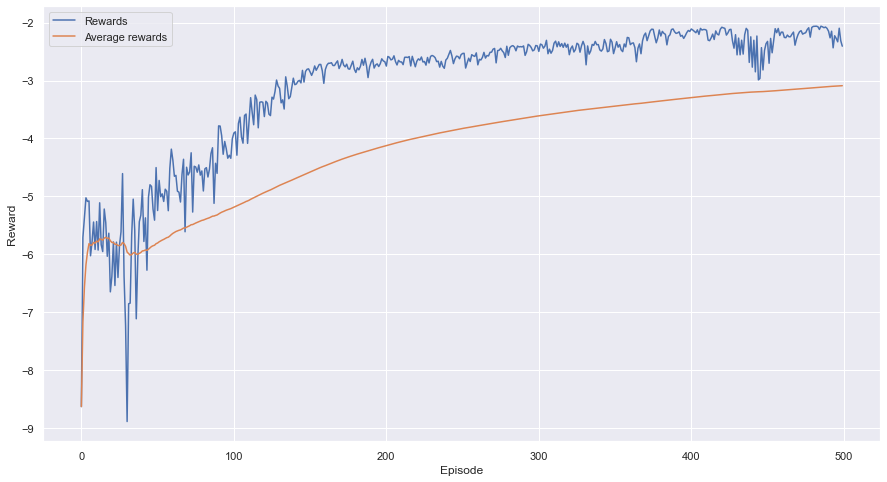

In [19]:
plt.plot(rewards,label='Rewards')
plt.plot(avg_rewards,label='Average rewards')
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [32]:
weights_predicted = env.weights_df 

In [33]:
freward_teacher(weights_predicted)

-0.022485266779693206

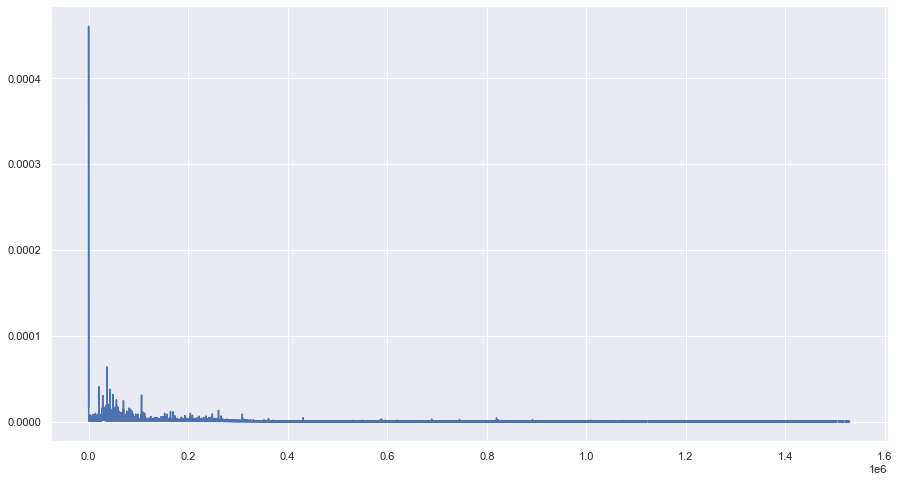

In [34]:
plt.plot(range(len(agent.critic_losses)),agent.critic_losses)
plt.show()

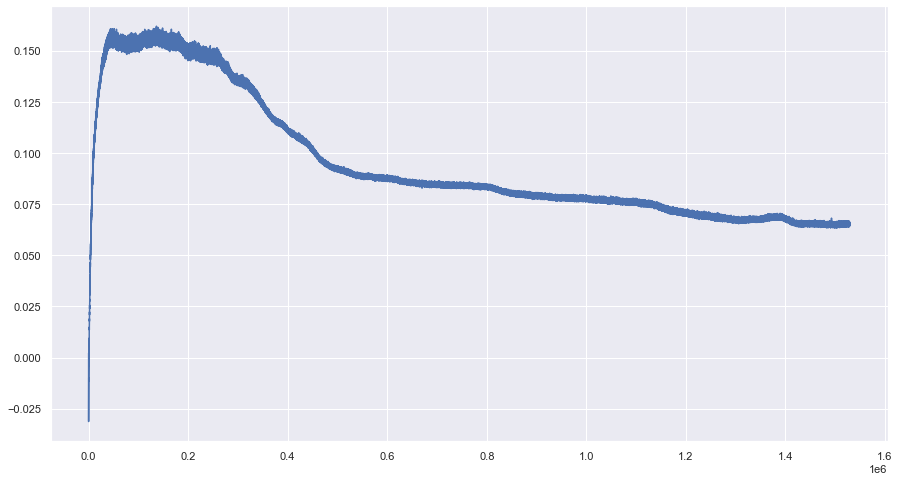

In [35]:
plt.plot(range(len(agent.actor_losses)),agent.actor_losses)
plt.show()

In [36]:
weights_predicted.head(20)

,Bloomberg Commodities,Dollar Index,EM Bond USD,EU Global Aggregate,EU HY,EU Stoxx 600,Japan Nikkei 225,MSCI EM USD,US Global Aggregate,US HY,US S&P 500
Date,,,,,,,,,,,
2010-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05,0.039616,0.043308,0.043696,0.054549,0.054343,0.056012,0.045136,0.047592,0.04373,0.044093,0.037261
2010-01-06,0.037552,0.044163,0.044828,0.050676,0.053854,0.060113,0.047623,0.048125,0.044135,0.040592,0.036916
2010-01-07,0.037075,0.047641,0.038534,0.04805,0.051294,0.061341,0.046959,0.044753,0.040684,0.043055,0.03588
2010-01-08,0.042504,0.047017,0.042318,0.05071,0.054202,0.060359,0.043509,0.04596,0.041009,0.04749,0.035029
2010-01-11,0.042104,0.042386,0.041169,0.053137,0.051619,0.058839,0.042265,0.047577,0.045436,0.046659,0.038858
2010-01-12,0.046422,0.044894,0.038228,0.053366,0.050676,0.054473,0.046891,0.047427,0.043861,0.051826,0.04227
2010-01-13,0.053307,0.051766,0.042779,0.058862,0.051163,0.055092,0.045361,0.047214,0.044864,0.049769,0.043906
2010-01-14,0.04664,0.056088,0.041483,0.060555,0.051518,0.057786,0.040964,0.04773,0.046303,0.048538,0.044294


In [37]:
pred_returns = pd.DataFrame()
pred_returns['Last Price'] = (1 + (weights_predicted * factors_returns).sum(axis=1)).cumprod().pct_change().fillna(0)

In [38]:
pred_returns.head()

,Last Price
Date,
2010-01-04,0.000000
2010-01-05,0.001629
2010-01-06,0.002017
2010-01-07,-0.000146
2010-01-08,0.001102


In [39]:
df['Agent price']= 100 * (1 + pred_returns['Last Price']).cumprod()

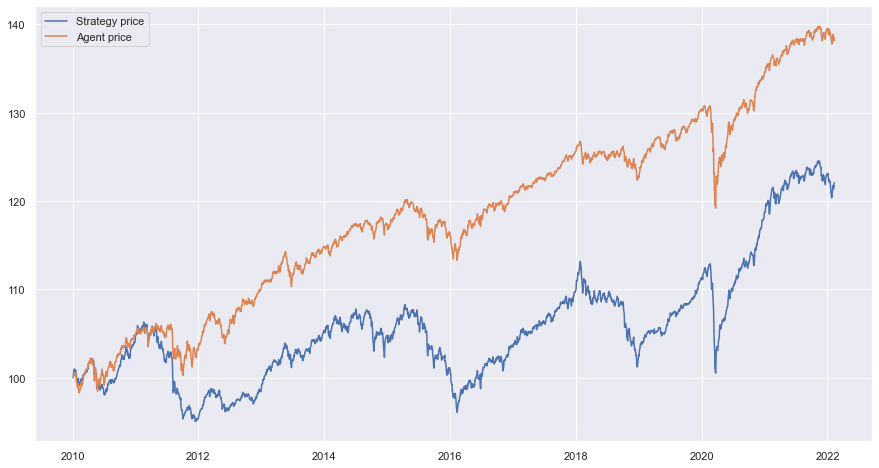

In [40]:
plt.plot(df[['Strategy price','Agent price']])
plt.legend(df[['Strategy price','Agent price']].columns,loc='upper left')

In [41]:
def create_submission(weights, factors_returns):
    # some financial computations
    weight_abs_diff = (weights - weights.shift(1)).abs().fillna(0)
    weight_abs_diff*= 0.0025 * 365 / ((weights.index[-1] - weights.index[0]).days) * np.sqrt(
        weights.shape[0] * (weights.shape[1]+1))
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    pred_returns*= np.sqrt(250) * np.sqrt(weights.shape[1]+1)
                    
    # format submission
    submission = pred_returns.to_frame() 
    submission.columns = ['Expected']
    submission.index = ['{:%Y-%m-%d}'.format(x) + '_returns' for x in pred_returns.index]
    
    for col in weight_abs_diff.columns:
        tmp = weight_abs_diff[col].to_frame()
        tmp.columns = ['Expected']
        tmp.index = [ '{:%Y-%m-%d}'.format(x) + '_{:}'.format(col) for x in tmp.index]
        submission = pd.concat([submission, tmp], axis=0)
    submission.index.names = ['Id']
    return submission
                    

In [44]:
submission = create_submission(best_env.weights_df , factors_returns)

In [46]:
submission.to_csv('submission.csv')

In [ ]:
best_env.weights_df.to_csv('best_weights.csv',index=False)